In [62]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install nibabel
!pip install pydicom

In [63]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib  
import pydicom
import json

## File Structure

In [64]:
data_dir = "/vol/miltank/projects/practical_sose25/atlas_based_registeration/data/dataset-myelom"
raw_data_dir = "/vol/miltank/projects/practical_sose25/atlas_based_registeration/data/dataset-myelom/rawdata"
preprocessed_data_dir = "/vol/miltank/projects/practical_sose25/atlas_based_registeration/data/dataset-myelom/preprocessed"
derivatives_data_dir = "/vol/miltank/projects/practical_sose25/atlas_based_registeration/data/dataset-myelom/derivatives"

files = os.listdir(data_dir)
files_raw = os.listdir(raw_data_dir)
files_preprocessed = os.listdir(preprocessed_data_dir)
files_derivatives = os.listdir(derivatives_data_dir)

print("files: ", files[:5])
print("raw files: ", files_raw[:5])
print("preprocessed files: ", files_preprocessed[:5])
print("derivative files: ", files_derivatives[:5])

files:  ['rawdata', 'preprocessed', 'derivatives']
raw files:  ['MM00228', 'MM00222', 'ctsr00714', 'MM00156', 'MM00121']
preprocessed files:  []
derivative files:  ['MM00254', 'MM00229', 'ctsr00714', 'MM00050', 'MM00027']


In [65]:
def print_folder_structure(root_dir, max_depth=4, prefix='', depth=0):
    if depth > max_depth:
        return
    try:
        entries = [e for e in os.listdir(root_dir) if not e.startswith('.')]
        dirs = [e for e in entries if os.path.isdir(os.path.join(root_dir, e))]
        files = [e for e in entries if os.path.isfile(os.path.join(root_dir, e))]
        print(f"{prefix}{os.path.basename(root_dir)}/")
        if files:
            print(f"{prefix}  (files: {files})")
        if dirs:
            print_folder_structure(os.path.join(root_dir, dirs[0]), max_depth, prefix + '  ', depth+1)
    except Exception as e:
        print(f"Error accessing {root_dir}: {e}")

print_folder_structure('/vol/miltank/projects/practical_sose25/atlas_based_registeration/data/dataset-myelom/rawdata', max_depth=5)
print('')
print_folder_structure('/vol/miltank/projects/practical_sose25/atlas_based_registeration/data/dataset-myelom/preprocessed', max_depth=5)
print('')
print_folder_structure('/vol/miltank/projects/practical_sose25/atlas_based_registeration/data/dataset-myelom/derivatives', max_depth=6)


rawdata/
  MM00228/
    ses-20220131/
      (files: ['sub-MM00228_ses-20220131_sequ-203_ct.nii.gz', 'sub-MM00228_ses-20220131_sequ-203_ct.json'])

preprocessed/

derivatives/
  MM00254/
    ses-20161206/
      (files: ['sub-MM00254_ses-20161206_sequ-202_seg-totalVibeSeg-gt-099_snp.jpg', 'sub-MM00254_ses-20161206_sequ-202_seg-totalVibeSeg-gt-099_desc-3D_snp.jpg', 'sub-MM00254_ses-20161206_sequ-202_seg-totalSeg_msk.nii.gz', 'sub-MM00254_ses-20161206_sequ-202_seg-bone_desc-3D_snp.jpg', 'sub-MM00254_ses-20161206_sequ-202_seg-totalVibeSeg-gt-099_msk.nii.gz', 'sub-MM00254_ses-20161206_sequ-202_seg-bone_msk.nii.gz', 'sub-MM00254_ses-20161206_sequ-202_seg-fullbody-gt-010_msk.nii.gz', 'sub-MM00254_ses-20161206_sequ-202_seg-spine_msk.nii.gz'])


In [66]:
root = "/vol/miltank/projects/practical_sose25/atlas_based_registeration/data/dataset-myelom/rawdata"
data = []
metadata = []

for patient in os.listdir(root):
    patient_path = os.path.join(root, patient)
    if not os.path.isdir(patient_path):
        continue
    for session in os.listdir(patient_path):
        session_path = os.path.join(patient_path, session)
        if not os.path.isdir(session_path):
            continue
        files = os.listdir(session_path)
        nii_files = [f for f in files if f.endswith(".nii.gz")]
        json_files = [f for f in files if f.endswith(".json")]
        for nii in nii_files:
            json_name = nii.replace(".nii.gz", ".json")
            json_exists = json_name in json_files
            json_path = os.path.join(session_path, json_name)
            meta = {}
            if os.path.exists(json_path):
                with open(json_path) as jf:
                    try:
                        meta = json.load(jf)
                    except Exception as e:
                        print(f"Fehler beim Laden: {json_path} ({e})")
            data.append({
                "Patient": patient,
                "Session": session,
                "CT_File": nii,
                "JSON_File": json_name,
                "JSON_exists": json_exists
            })
            metadata.append({
                "Patient": patient,
                "Session": session,
                "CT_File": nii,
                "Manufacturer": meta.get("Manufacturer"),
                "Model": meta.get("ManufacturerModelName"),
                "Age": meta.get("PatientAge"),
                "Sex": meta.get("PatientSex"),
                "Slices": meta.get("Slices"),
                "SliceThickness": meta.get("SliceThickness"),
                "PixelSpacing": meta.get("PixelSpacing"),
                "Date": meta.get("AcquisitionDate"),
            })

            

## Metadata of CT scans

In [67]:
with open('/vol/miltank/projects/practical_sose25/atlas_based_registeration/data/dataset-myelom/rawdata/MM00228/ses-20220131/sub-MM00228_ses-20220131_sequ-203_ct.json') as f:
    meta_dict = json.load(f)

print(meta_dict)
for i in meta_dict:
    print(i,':', meta_dict[i])

{'dataset': 'myelom', 'AcquisitionDate': 20220101, 'CTDIvol': 3.5702559598497725, 'ConvolutionKernel': 'YB', 'FilterType': 'YB', 'KVP': 120.0, 'Manufacturer': 'Philips', 'ManufacturerModelName': 'IQon - Spectral CT', 'PatientAge': '073Y', 'PatientSex': 'M', 'PatientWeight': 0.0, 'PixelSpacing': [0.4502712, 0.4502712], 'SliceThickness': 3.0, 'TableHeight': 149.8, 'SeriesDescription': 'GK 3mm cor, iDose (4)', 'StudyDescription': 'CT Ganzkörper knöchern + MPR (3D)', 'ImageType': ['DERIVED', 'SECONDARY', 'MPR'], 'Slices': 124, 'ImageOrientationPatient': [1.0, 0.0, 0.0, 0.0, 0.0, -1.0], 'PatientPosition': 'HFS'}
dataset : myelom
AcquisitionDate : 20220101
CTDIvol : 3.5702559598497725
ConvolutionKernel : YB
FilterType : YB
KVP : 120.0
Manufacturer : Philips
ManufacturerModelName : IQon - Spectral CT
PatientAge : 073Y
PatientSex : M
PatientWeight : 0.0
PixelSpacing : [0.4502712, 0.4502712]
SliceThickness : 3.0
TableHeight : 149.8
SeriesDescription : GK 3mm cor, iDose (4)
StudyDescription : CT

     Patient       Session                                        CT_File  \
0    MM00228  ses-20220131    sub-MM00228_ses-20220131_sequ-203_ct.nii.gz   
1    MM00222  ses-20190102    sub-MM00222_ses-20190102_sequ-202_ct.nii.gz   
2  ctsr00714  ses-20161227  sub-ctsr00714_ses-20161227_sequ-201_ct.nii.gz   
3  ctsr00714  ses-20210729  sub-ctsr00714_ses-20210729_sequ-203_ct.nii.gz   
4  ctsr00714  ses-20190327  sub-ctsr00714_ses-20190327_sequ-202_ct.nii.gz   

  Manufacturer               Model   Age Sex  Slices  SliceThickness  \
0      Philips  IQon - Spectral CT  073Y   M   124.0             3.0   
1      Philips  IQon - Spectral CT  049Y   M  1580.0             0.9   
2      Philips             iCT 256  035Y   F  1599.0             0.9   
3      Philips  IQon - Spectral CT  040Y   F   125.0             3.0   
4      Philips             iCT 256  037Y   F  1893.0             0.9   

             PixelSpacing        Date  
0  [0.4502712, 0.4502712]  20220101.0  
1  [0.9765625, 0.9765625

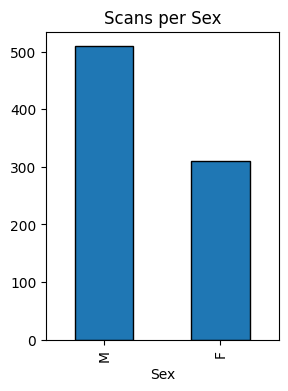

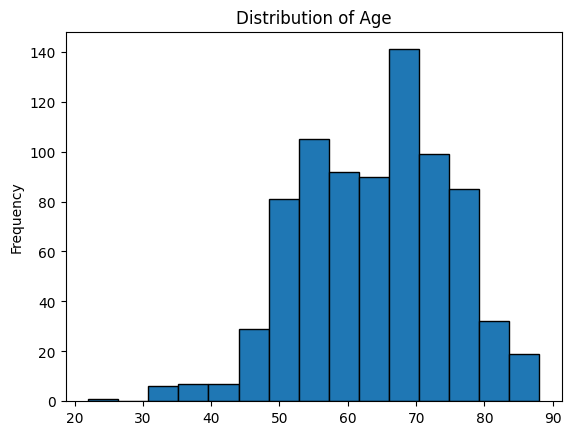

Manufacturer
Philips    494
SIEMENS    325
Name: count, dtype: int64


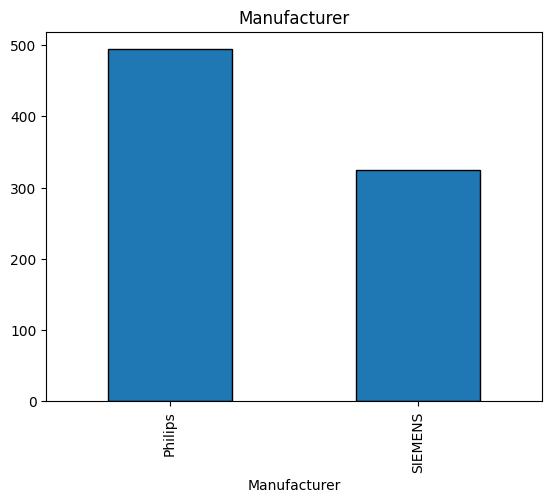

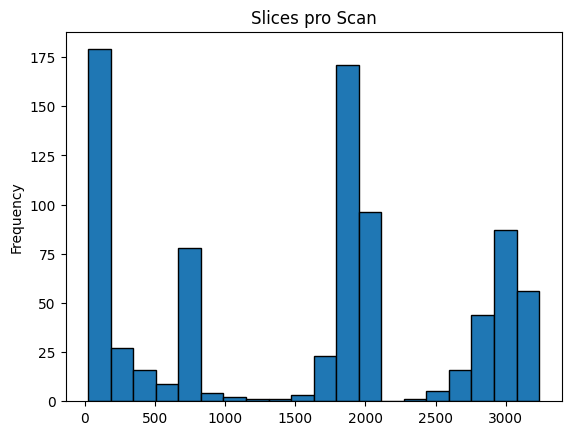

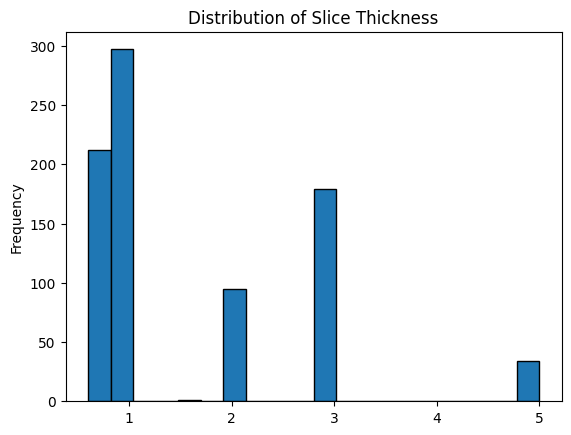

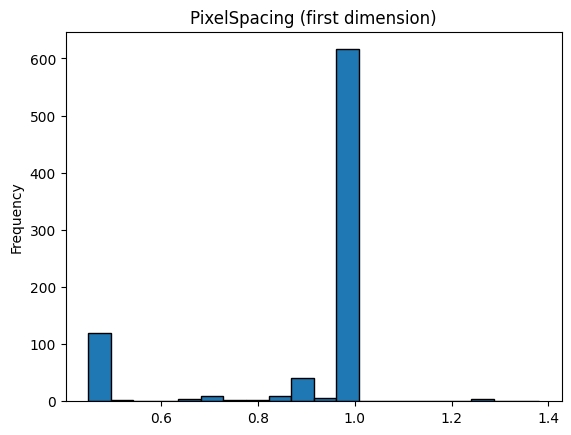

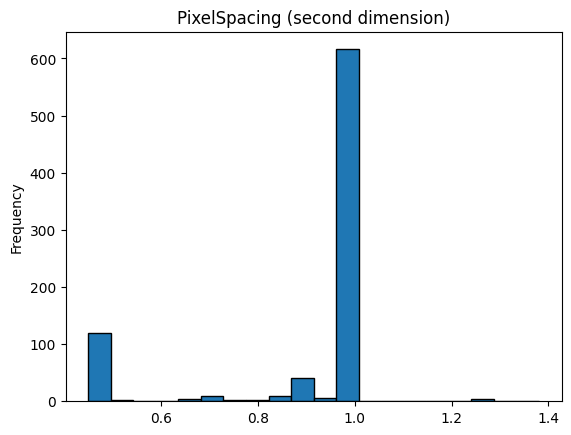

In [98]:
df = pd.DataFrame(metadata)
print(df.head(), "\n")

print(df["Sex"].value_counts())
df["Sex"].value_counts().plot(kind='bar', title="Scans per Sex", edgecolor='k',figsize = (3,4))
plt.show()

df["AgeNum"] = df["Age"].str.extract(r'(\d+)').astype(float)
df["AgeNum"].plot(kind='hist', bins=15, title="Distribution of Age", edgecolor='k')
plt.show()

print(df["Manufacturer"].value_counts())
df["Manufacturer"].value_counts().plot(kind='bar', title="Manufacturer", edgecolor='k')
plt.show()

df["Slices"].plot(kind='hist', bins=20, title="Slices pro Scan", edgecolor='k')
plt.show()

df["SliceThickness"].plot(kind='hist', bins=20, title="Distribution of Slice Thickness", edgecolor='k')
plt.show()

pixelspacing0 = df["PixelSpacing"].apply(lambda x: x[0] if isinstance(x, list) else None)
pixelspacing0.plot(kind='hist', bins=20, title="PixelSpacing (first dimension)", edgecolor='k')
plt.show()

pixelspacing0 = df["PixelSpacing"].apply(lambda x: x[1] if isinstance(x, list) else None)
pixelspacing0.plot(kind='hist', bins=20, title="PixelSpacing (second dimension)", edgecolor='k')
plt.show()

## Dataset Statistics

     Patient       Session                                        CT_File  \
0    MM00228  ses-20220131    sub-MM00228_ses-20220131_sequ-203_ct.nii.gz   
1    MM00222  ses-20190102    sub-MM00222_ses-20190102_sequ-202_ct.nii.gz   
2  ctsr00714  ses-20161227  sub-ctsr00714_ses-20161227_sequ-201_ct.nii.gz   
3  ctsr00714  ses-20210729  sub-ctsr00714_ses-20210729_sequ-203_ct.nii.gz   
4  ctsr00714  ses-20190327  sub-ctsr00714_ses-20190327_sequ-202_ct.nii.gz   

                                     JSON_File  JSON_exists  
0    sub-MM00228_ses-20220131_sequ-203_ct.json         True  
1    sub-MM00222_ses-20190102_sequ-202_ct.json         True  
2  sub-ctsr00714_ses-20161227_sequ-201_ct.json         True  
3  sub-ctsr00714_ses-20210729_sequ-203_ct.json         True  
4  sub-ctsr00714_ses-20190327_sequ-202_ct.json         True  

          Patient       Session  \
657  derivatives  ses-20151009   

                                               CT_File  \
657  sub-MM00201_ses-20151009_sequ-3

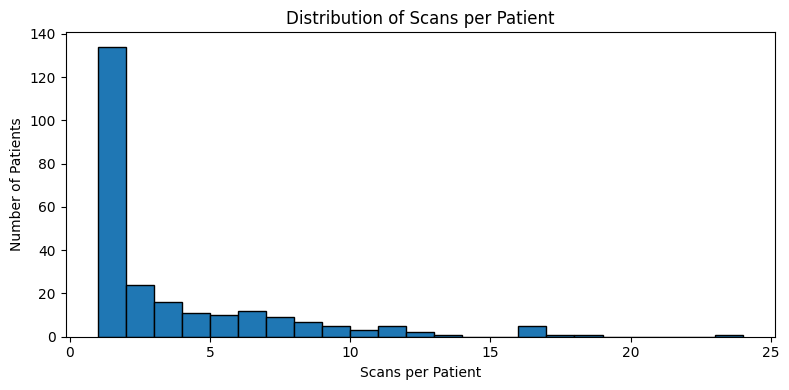

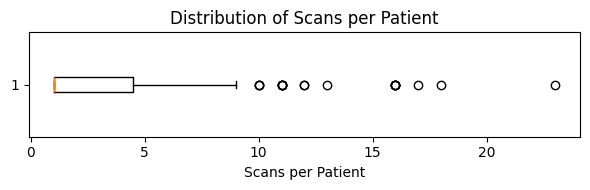


Sessions per Patient: Patient
CTFU00065     4
CTFU00066    14
CTFU00068     9
CTFU00099     4
CTFU00112     6
Name: Session, dtype: int64


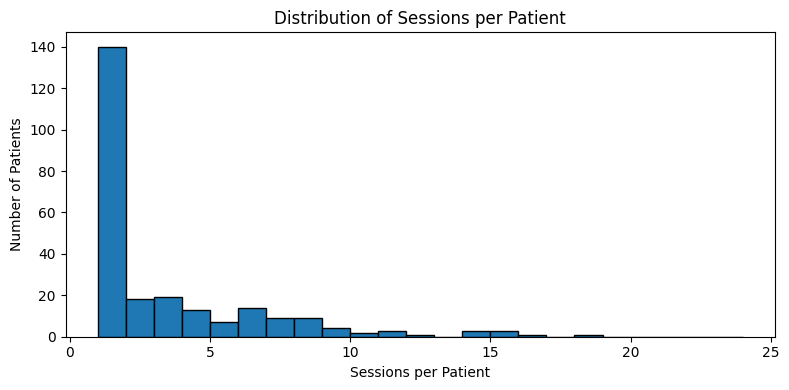

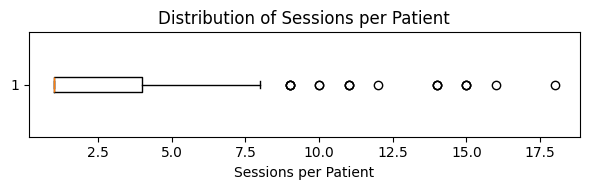

In [71]:
df = pd.DataFrame(data)
print(df.head())
print("\n", df[~df["JSON_exists"]])
print("\nNumber of Patients:", df['Patient'].nunique())

scan_counts = df.groupby("Patient")["CT_File"].count()
print("\nScans per Patient:", scan_counts.head())

max_scans = df_test.max()
top_patient = scan_counts.idxmax()
print("\nMax Scans of:", top_patient, " with", max_scans, "scans")

plt.figure(figsize=(8,4))
plt.hist(scan_counts.values, bins=range(1, scan_counts.values.max()+2), edgecolor='k')
plt.xlabel('Scans per Patient')
plt.ylabel('Number of Patients')
plt.title('Distribution of Scans per Patient')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,2))
plt.boxplot(scan_counts.values, vert=False)
plt.xlabel('Scans per Patient')
plt.title('Distribution of Scans per Patient')
plt.tight_layout()
plt.show()

session_counts = df.groupby("Patient")["Session"].nunique()
print("\nSessions per Patient:", session_counts.head())

plt.figure(figsize=(8,4))
plt.hist(session_counts.values, bins=range(1, scan_counts.values.max()+2), edgecolor='k')
plt.xlabel('Sessions per Patient')
plt.ylabel('Number of Patients')
plt.title('Distribution of Sessions per Patient')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,2))
plt.boxplot(session_counts.values, vert=False)
plt.xlabel('Sessions per Patient')
plt.title('Distribution of Sessions per Patient')
plt.tight_layout()
plt.show()



In [70]:
df["Shape"] = None

for idx, row in df.iterrows():
    nii_path = os.path.join(root, row["Patient"], row["Session"], row["CT_File"])
    img = nib.load(nii_path)
    df.at[idx, "Shape"] = img.shape

print(df.head())

     Patient       Session                                        CT_File  \
0    MM00228  ses-20220131    sub-MM00228_ses-20220131_sequ-203_ct.nii.gz   
1    MM00222  ses-20190102    sub-MM00222_ses-20190102_sequ-202_ct.nii.gz   
2  ctsr00714  ses-20161227  sub-ctsr00714_ses-20161227_sequ-201_ct.nii.gz   
3  ctsr00714  ses-20210729  sub-ctsr00714_ses-20210729_sequ-203_ct.nii.gz   
4  ctsr00714  ses-20190327  sub-ctsr00714_ses-20190327_sequ-202_ct.nii.gz   

                                     JSON_File  JSON_exists              Shape  
0    sub-MM00228_ses-20220131_sequ-203_ct.json         True  (1106, 3986, 124)  
1    sub-MM00222_ses-20190102_sequ-202_ct.json         True   (512, 512, 1580)  
2  sub-ctsr00714_ses-20161227_sequ-201_ct.json         True   (512, 512, 1599)  
3  sub-ctsr00714_ses-20210729_sequ-203_ct.json         True  (1106, 3714, 125)  
4  sub-ctsr00714_ses-20190327_sequ-202_ct.json         True   (512, 512, 1893)  
